In [1]:
!pip install folium --quiet

In [2]:
import pandas as pd
from pymongo import MongoClient
from mongo_aggregation_verbs import *

%matplotlib inline

mongo_client = MongoClient('18.236.138.158', 27016)
database_reference = mongo_client.twitter

| | | | | |
|-|-|-|-|-|
| `_id`        | `truncated`                 |`user`            |`extended_tweet` | `favorited`                   |
| `created_at` | `in_reply_to_status_id`     |`geo`             |`quote_count`    | `retweeted`                   |
| `id`         | `in_reply_to_status_id_str` |`coordinates`     |`reply_count`    | `filter_level`                |
| `id_str`     | `in_reply_to_user_id`       |`place`           |`retweet_count`  | `lang`                        |
| `text`       | `in_reply_to_user_id_str`   |`contributors`    |`favorite_count` | `timestamp_ms`                |
| `source`     | `in_reply_to_screen_name`   |`is_quote_status` |`entities`       |                               |
























![](https://www.evernote.com/l/AAEO7gpKcKdI5YJeGrni4GhdlBiBWdTa3YgB/image.png)

In [3]:
collection_reference = database_reference.instructor_test_group

In [4]:
collection_reference.count()

20000

## Tweets By Day

In [5]:
datestring_created_at = { "dateString" : "$created_at"}
date_from_string = {"$dateFromString" : datestring_created_at }

date_to_id = {
    PROJECT : {
        "_id" : 0,
        "year"  : {"$year"       : {"date" : date_from_string}},
        "month" : {"$month"      : {"date" : date_from_string}},
        "day"   : {"$dayOfMonth" : {"date" : date_from_string}},
    }
}

group_by_date = {
    GROUP : {
        "tweets" : { "$sum" : 1 },
        "_id" : {
            "year"  : "$year",
            "month" : "$month",
            "day"   : "$day"
        },
    }
}



In [6]:
def dictionary_to_datestring(x):
    month = x['month']
    day   = x['day']
    year  = x['year']
    return "{}-{}-{}".format(month, day, year)

In [7]:
cursor = collection_reference.aggregate([
    date_to_id,
    group_by_date
])

daily_tweets = pd.DataFrame(list(cursor))

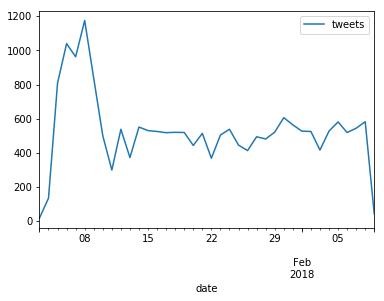

In [8]:
datestrings = daily_tweets['_id'].apply(dictionary_to_datestring)
daily_tweets['date'] = pd.to_datetime(datestrings)

daily_tweets.drop('_id', axis=1, inplace=True)
daily_tweets.sort_values('date', inplace=True)
daily_tweets.set_index('date', inplace=True)
daily_tweets.plot()

## Tweet Locations

In [9]:
not_null = { '$ne' : None }
nonnull_geo = {'geo' : not_null }
keep_geo = { 'geo' : 1 }

cursor = collection_reference.find(nonnull_geo, keep_geo)
cursor.count()

2952

In [10]:
geo_tweets = pd.DataFrame(list(cursor))

In [11]:
def parse_geo_from_tweets(tweets):
    geo = pd.DataFrame(list(tweets['geo'].values))
    return geo

In [12]:
geo = parse_geo_from_tweets(geo_tweets)
geo.sample(5)

,coordinates,type
1223,"[34.1569, -118.4487]",Point
1510,"[34.0522, -118.243]",Point
1493,"[34.0534368, -118.4046509]",Point
166,"[34.952056, -117.891088]",Point
1849,"[34.3333, -118.133]",Point


In [13]:
import folium
starting_loc = [34.0689, -118.4452]
la_map = folium.Map(location=starting_loc, zoom_start=13)

In [14]:
for loc in geo.coordinates.values:
    folium.Marker(loc).add_to(la_map)

In [15]:
la_map